In [1]:
% matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from collections import namedtuple
import heapq
import seaborn as sns

from market import SimulationClock
from market import Exchange

In [2]:
def bgt_scheduler( clock, FV, p_flex, lam, order_size_bound, trader):
    order_type = 0
    delta_t = np.random.exponential(lam)
    quantity = np.random.randint(1,order_size_bound+1)*np.random.choice([-1,1])
    price = FV + np.random.randint(-p_flex,p_flex+1)
    heapq.heappush(event_queue,[clock.time+delta_t, price,quantity,trader,order_type])

def agressor_scheduler(a1, a2, a3, b1, b2, b3, c1, c2, c3, d1, d2, d3, clock, lam, ba, bb, lastprice, depth, trader):
    order_type = 0
    delta_t = np.random.exponential(lam)
    if lastprice >= ba:
        quantity = a1*(lastprice - ba) + b1*depth
        price = c1*lastprice + d1*depth
    elif lastprice < bb:
        quantity = a2*(lastprice - bb) - b2*depth
        price = c2*lastprice + d2*depth
    else:
        quantity = 0
        price = c3*lastprice + d3*depth
    
    heapq.heappush(event_queue,[clock.time+delta_t, price, quantity, trader, order_type])
    pass

def mm1_scheduler(clock, e1, f1, ba, bb, trader):
    order_type = 0
    lam = e1
    delta_t = np.random.exponential(lam)
    buy_sell_sign = np.random.choice([-1,1])
    if buy_sell_sign > 0:
        price = bb
        quantity = buy_sell_sign*f1
    else:
        price = ba
        quantity = buy_sell_sign*f1
    
    heapq.heappush(event_queue,[clock.time+delta_t, price, quantity, trader, order_type])
    pass

def mm2_scheduler(clock, g1, h1, i1, j1, lam, mm2_q, ba, bb, trader):
    order_type = 0
    delta_t = np.random.exponential(lam)
    buy_sell_sign = np.random.choice([-1,1])
    if buy_sell_sign > 0:
        price = min(bb+g1,ba-h1)
        quantity = buy_sell_sign*mm2_q
    else:
        price = max(bb+i1,ba-j1)
        quantity = buy_sell_sign*mm2_q
    
    heapq.heappush(event_queue,[clock.time+delta_t, price, quantity, trader, order_type])
    pass

def mm3_scheduler(clock, g1, h1, i1, j1, k1, l1, ba, bb, trader):
    order_type = 0
    delta_t = np.random.exponential(k1)
    buy_sell_sign = np.random.choice([-1,1])
    if buy_sell_sign > 0:
        price = min(bb+g1,max(ba-h1,bb))
        quantity = buy_sell_sign*l1
    else:
        price = max(min(bb+i1,ba),ba-j1)
        quantity = buy_sell_sign*l1
    
    heapq.heappush(event_queue,[clock.time+delta_t, price, quantity, trader, order_type])
    pass


In [3]:
generations = 20
population_size = 50
selection = 10
n_params = 2
mutation_rate = 0.5
mutation_decay = 0.90
num_of_smart_robot = 1

sim_duration = 50
burn_in = 5
n_bgts = 100

# parameters 
e1 = np.random.uniform(0.4,1,population_size)
f1 = np.random.uniform(0,20,population_size)
g1 = np.random.uniform(0,5,population_size)
h1 = np.random.uniform(0,5,population_size)
i1 = np.random.uniform(0,5,population_size)
j1 = np.random.uniform(0,5,population_size)
k1 = np.random.uniform(0.4,1,population_size)
l1 = np.random.uniform(0,20,population_size)

def mutate1(idx):
    if idx == 0:
        return np.random.uniform(0.4,1)
    elif idx == 1:
        return np.random.uniform(0,20)

    
def mutate2(idx):
    if idx == 0:
        return np.random.uniform(0,5)
    elif idx == 1:
        return np.random.uniform(0,5)
    elif idx == 2:
        return np.random.uniform(0,5)
    elif idx == 3:
        return np.random.uniform(0,5)

population1 = list(zip(e1,f1))
population2 = list(zip(g1,h1,i1,j1))

population1_record = []
population2_record = []

for gen in range(generations): 
    population1_record.append(population1)
    population2_record.append(population2)

# simulate
    events = []
    FVs = []
    clk = SimulationClock()
    exch = Exchange(clk)
    BAs = []
    BBs = []
    t=0

    order_size_bound = 100
    FV = 100
    p_flex = 3
    p_reset = 0.01
    lam_bgt = 0.5
    lam_mm = 0.5

    event_queue = []

    #init
    for trader in range(0,n_bgts):
        bgt_scheduler(clk, FV, p_flex, lam_bgt, order_size_bound, trader)

    #burn_in
    while clk.time < burn_in:
        # execute next event
        event = heapq.heappop(event_queue)
        event_time, price, quantity, trader, order_type = event
        clk.time = event_time
        exch.post(price, quantity, trader, order_type)
        # reset FV
        if trader < n_bgts:
            if np.random.rand(1) < p_reset:
                FV = price
        # schedule new event
        bgt_scheduler(clk, FV, p_flex, lam_bgt, order_size_bound, trader)

        # stats
        events.append([clk.time,event[2],event[1]]) 
        FVs.append(FV)
        ba = exch.get_best_ask()
        bb = exch.get_best_bid()
        if ba == None:
            ba_price = FV
        else:
            ba_price = ba.price
        if bb == None:
            bb_price = FV
        else:
            bb_price = -bb.price
        BAs.append(ba_price)
        BBs.append(bb_price)

    depth = BAs[-1] - BAs[-2] - BBs[-1] + BBs[-2]
    
    for trader in range(n_bgts,n_bgts+population_size):
        k = trader - n_bgts
        params = population1[k]
        mm1_scheduler(clk, params[0], params[1], BAs[-1], BBs[-1], trader)

    
    for trader in range(n_bgts+population_size,n_bgts+2*population_size):
        k = trader - n_bgts - population_size
        params = population2[k]
        mm3_scheduler(clk, params[0], params[1], params[2], params[3], lam_mm, 20, BAs[-1], BBs[-1], trader)

    while clk.time < sim_duration:
        # execute next event
        event = heapq.heappop(event_queue)
        event_time, price, quantity, trader, order_type = event
        clk.time = event_time
        exch.post(price, quantity, trader, order_type)
        # reset FV
        if trader < n_bgts:
            if np.random.rand(1) < p_reset:
                FV = price

        # stats
        events.append([clk.time,event[2],event[1]]) 
        FVs.append(FV)
        ba = exch.get_best_ask()
        bb = exch.get_best_bid()
        if ba == None:
            ba_price = FV
        else:
            ba_price = ba.price
        if bb == None:
            bb_price = FV
        else:
            bb_price = -bb.price
        BAs.append(ba_price)
        BBs.append(bb_price)

        depth = BAs[-1] - BAs[-2] - BBs[-1] + BBs[-2]

        # schedule new event
        if trader >= n_bgts + population_size:
            k = trader - n_bgts - population_size
            params = population2[k]
            mm3_scheduler(clk, params[0], params[1], params[2], params[3], lam_mm, 20, BAs[-1], BBs[-1], trader)        
        elif trader >= n_bgts:
            k = trader - n_bgts
            params = population1[k]
            mm1_scheduler(clk, params[0], params[1], BAs[-1], BBs[-1], trader)
        else:    
            bgt_scheduler(clk, FV, p_flex, lam_bgt, order_size_bound, trader)
    
    # profit calculation
    trades = np.array(exch.trades)
    profit1=[]
    for i in range(n_bgts,n_bgts+population_size):
        profit1.append(-sum(trades[trades[:,4]==i][:,3]*trades[trades[:,4]==i][:,6]*trades[trades[:,4]==i][:,2]) 
                      +sum(trades[trades[:,5]==i][:,3]*trades[trades[:,5]==i][:,6]*trades[trades[:,5]==i][:,2])
                      +(sum(trades[trades[:,4]==i][:,3]*trades[trades[:,4]==i][:,6])
                      -sum(trades[trades[:,5]==i][:,3]*trades[trades[:,5]==i][:,6]))*exch.lastprice)
    profit2=[]
    for i in range(n_bgts+population_size,n_bgts + 2*population_size):
        profit2.append(-sum(trades[trades[:,4]==i][:,3]*trades[trades[:,4]==i][:,6]*trades[trades[:,4]==i][:,2]) 
                      +sum(trades[trades[:,5]==i][:,3]*trades[trades[:,5]==i][:,6]*trades[trades[:,5]==i][:,2])
                      +(sum(trades[trades[:,4]==i][:,3]*trades[trades[:,4]==i][:,6])
                      -sum(trades[trades[:,5]==i][:,3]*trades[trades[:,5]==i][:,6]))*exch.lastprice)
# evolution
    profit1 = np.array(profit1)
    population1 = np.array(population1)
    top_traders1 = profit1.argsort()[-selection:][::-1]
    #print(top_traders)
    top_profit1 = profit1[top_traders1]
    top_params1 = population1[top_traders1]
    
    profit2 = np.array(profit2)
    population2 = np.array(population2)
    top_traders2 = profit2.argsort()[-selection:][::-1]
    #print(top_traders)
    top_profit2 = profit2[top_traders2]
    top_params2 = population2[top_traders2]
    
    print('gen',gen)
    print('mutation_rate',mutation_rate)
    print('top profit1\n',top_profit1)
    print('top parameters1\n',top_params1)
    print('top profit2\n',top_profit2)
    print('top parameters2\n',top_params2)
    
    new_params1 = []
    for i in range(top_params1.shape[1]):
        new_params1.append(np.random.choice(top_params1[:,i],population_size))
    
    new_params2 = []
    for i in range(top_params2.shape[1]):
        new_params2.append(np.random.choice(top_params2[:,i],population_size))
    
    population1 = np.column_stack(new_params1)
    for i in range(population_size):
        for j in range(len(population1[i])):
            if np.random.rand(1) < mutation_rate:
                population1[i][j] = mutate1(j)
    
    population2 = np.column_stack(new_params2)
    for i in range(population_size):
        for j in range(len(population2[i])):
            if np.random.rand(1) < mutation_rate:
                population2[i][j] = mutate2(j)
    #population = population[:population_size]
    #population
    
    mutation_rate = mutation_rate * mutation_decay
    
    


gen 0
mutation_rate 0.5
top profit1
 [ 1014.88473445   679.30962332   656.21417654   436.35595098   384.57865913
   363.66800812   316.21004735   279.2604693    257.88988248   184.27269592]
top parameters1
 [[  0.46356148  14.69228629]
 [  0.5387315   13.69561149]
 [  0.95486512  19.32875796]
 [  0.91788492  19.99828941]
 [  0.57825685  14.44706431]
 [  0.64167614  17.26999413]
 [  0.66065047  13.78852332]
 [  0.63289958   6.47946283]
 [  0.67177199   8.7140012 ]
 [  0.4785171    3.05431757]]
top profit2
 [ 1224.1472214   1184.9816632    915.4510554    751.46230831   744.06618838
   741.92755356   689.86403046   657.69402002   633.79579087   628.99099198]
top parameters2
 [[ 3.22639484  2.09362541  1.3501632   2.82015075]
 [ 3.10266427  2.41116568  2.92738248  0.50441806]
 [ 3.70321801  3.71505864  4.48728792  0.75575757]
 [ 0.71724338  1.12711261  1.1483507   4.02947495]
 [ 3.42381797  4.05903133  1.8249073   3.92439849]
 [ 4.90492507  4.63382102  2.15467503  2.73452089]
 [ 2.82156513

gen 7
mutation_rate 0.23914845000000007
top profit1
 [ 441.32700545  435.31209149  350.05316248  212.73597699  183.73253919
   69.21497927   -7.67744163  -29.01317977  -40.30537     -96.77606057]
top parameters1
 [[  0.51512401  12.9579939 ]
 [  0.5728647   17.28136823]
 [  0.80634786  17.28136823]
 [  0.63343216  14.51306949]
 [  0.87952441   3.54279938]
 [  0.5728647   11.00655274]
 [  0.5728647    0.12024902]
 [  0.5728647   14.91294474]
 [  0.87952441  11.64642287]
 [  0.63343216   3.84069116]]
top profit2
 [ 1169.88180573   501.36740879   182.8249593     75.18693344  -265.79257767
  -295.54809069  -449.92773655  -485.36015823  -719.53503674  -942.65724848]
top parameters2
 [[ 1.1752381   0.25666496  3.95917811  3.48405967]
 [ 2.58719181  2.71666772  2.30160721  4.02947495]
 [ 0.66769435  3.72705419  2.30160721  4.02947495]
 [ 0.66769435  1.06927042  3.36551953  3.28907176]
 [ 0.03297684  2.71666772  3.10297996  4.53771606]
 [ 1.57660864  2.71666772  3.95917811  4.73760565]
 [ 0.66

gen 14
mutation_rate 0.11438396227480506
top profit1
 [ 708.77465736  645.95579773  617.64286778  600.90910238  537.91258214
  489.47380266  478.81042785  461.14789914  452.4995149   420.68974243]
top parameters1
 [[  0.79970527  14.91294474]
 [  0.54150651  11.24438983]
 [  0.51512401  13.94220443]
 [  0.97433422  16.62828795]
 [  0.61228732  17.28136823]
 [  0.4546666   14.91294474]
 [  0.61228732  17.28136823]
 [  0.51512401  17.28136823]
 [  0.4546666   14.91294474]
 [  0.97433422  14.72266565]]
top profit2
 [ 1820.17945617  1465.16940366  1280.76040078  1277.95890428  1169.52552922
  1163.04903485  1126.01500514  1057.94403335   974.95131189   759.46441879]
top parameters2
 [[ 1.64303203  3.03771753  1.52171172  4.41360402]
 [ 0.66769435  3.03771753  1.52171172  0.39410225]
 [ 1.97176696  3.03771753  0.25499976  2.91604563]
 [ 1.7765473   2.71666772  3.90429607  4.41360402]
 [ 2.95993347  3.03771753  0.28161648  2.91604563]
 [ 2.95993347  2.71666772  1.52171172  2.91604563]
 [ 1.7

In [7]:
import pandas as pd

In [31]:
e1_record = pd.DataFrame(np.array(population1_record)[:,:,0])
e1_record = e1_record.add_prefix('lambda').reset_index()
e1_record = pd.wide_to_long(e1_record,stubnames=["lambda"],i='index',j="id").reset_index()

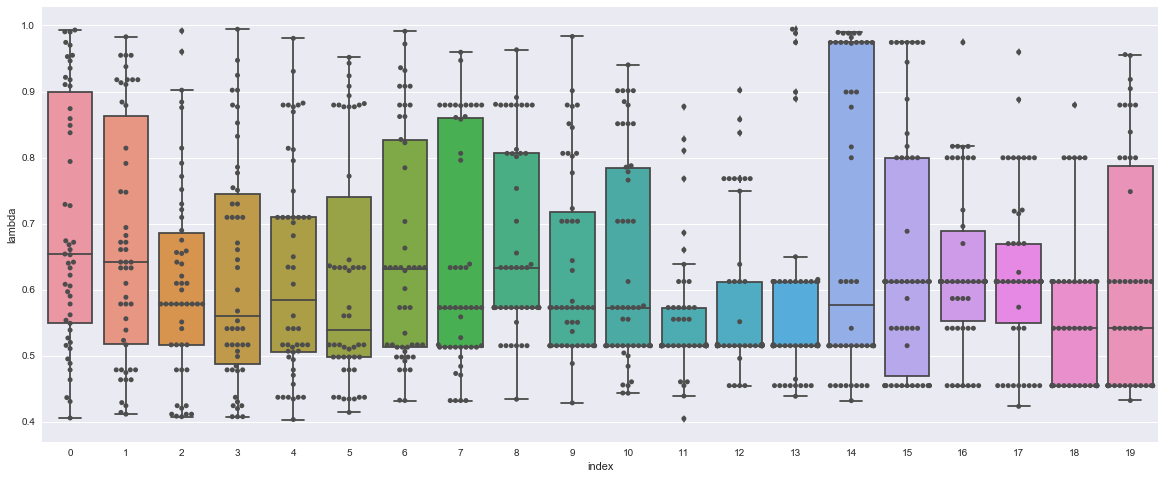

In [41]:
plt.figure(figsize=(20,8))
sns.boxplot(x="index", y="lambda", data=e1_record)
#sns.stripplot(x="index", y="lambda", data=e1_record, jitter=True, color=".3")
sns.swarmplot(x="index", y="lambda", data=e1_record, color=".3")

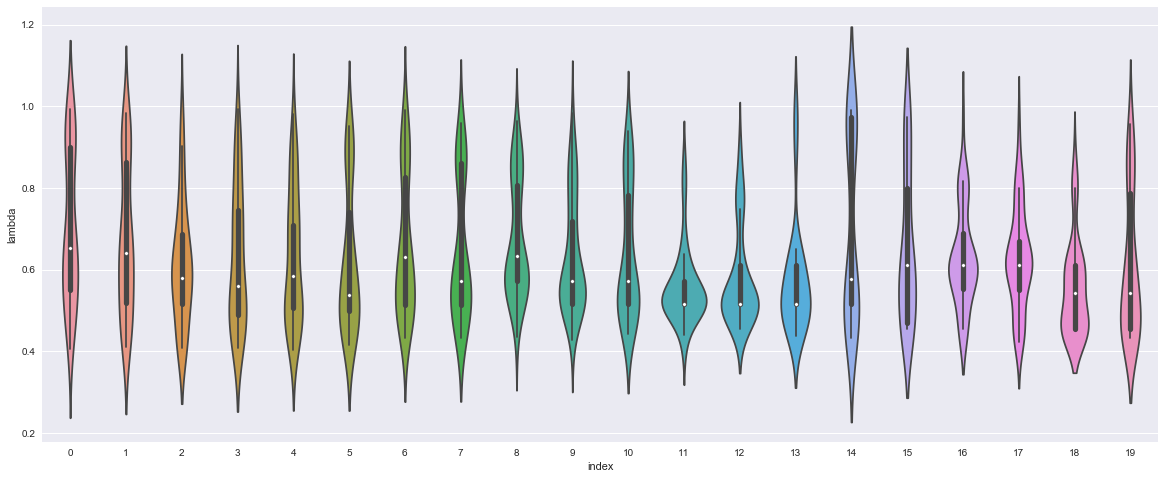

In [40]:
plt.figure(figsize=(20,8))
sns.violinplot(x="index", y="lambda", data=e1_record)

In [4]:
trades = np.array(exch.trades)
#exch.trades

In [5]:
events = np.array(events)

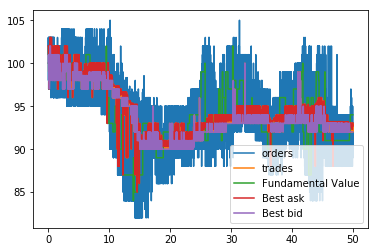

In [6]:
plt.plot(events[:,0],events[:,2], label = 'orders')
plt.plot(trades[:,0],trades[:,2], label = 'trades')
plt.plot(events[:,0],FVs, label = 'Fundamental Value')
plt.plot(events[:,0],BAs, label = 'Best ask')
plt.plot(events[:,0],BBs, label = 'Best bid')
plt.legend()

In [131]:
#list(zip(BAs,BBs))
#np.sort(np.array(exch.bids,dtype = [('price', int), ('t', float), ('quantity', int), ('trader', int), ('order_type', int)]),order=['price','t'])
#np.sort(np.array(exch.asks,dtype = [('price', int), ('t', float), ('quantity', int), ('trader', int), ('order_type', int)]),order=['price','t'])
#len(events)